Here's the code I use to read in SIMBA files and make 2D plots of temperature and associated variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
import datetime
# import cmocean
from matplotlib.dates import DateFormatter
import glob

In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [4]:
simba_filepath = '/psd3data/arctic/raven/simba/level1/'
lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## on our server the simba files include some days from march during testing; this gets rid of those files
lev1_files = lev1_files[5:]

In [6]:
## these are the only variables I've used so far from the SIMBA
varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = datetime.datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
        
    ## shape of temperature is (time, height)
    print(season_data['dates'].shape, season_data['height'].shape, season_data['temperature'].shape)

(96,) (241,) (96, 241)
(192,) (241,) (192, 241)
(288,) (241,) (288, 241)
(384,) (241,) (384, 241)
(480,) (241,) (480, 241)
(576,) (241,) (576, 241)
(672,) (241,) (672, 241)
(768,) (241,) (768, 241)
(864,) (241,) (864, 241)
(960,) (241,) (960, 241)
(1056,) (241,) (1056, 241)
(1152,) (241,) (1152, 241)
(1248,) (241,) (1248, 241)
(1344,) (241,) (1344, 241)
(1440,) (241,) (1440, 241)
(1536,) (241,) (1536, 241)
(1632,) (241,) (1632, 241)
(1728,) (241,) (1728, 241)
(1824,) (241,) (1824, 241)
(1920,) (241,) (1920, 241)
(2016,) (241,) (2016, 241)
(2112,) (241,) (2112, 241)
(2208,) (241,) (2208, 241)
(2304,) (241,) (2304, 241)
(2400,) (241,) (2400, 241)
(2496,) (241,) (2496, 241)
(2592,) (241,) (2592, 241)
(2688,) (241,) (2688, 241)
(2784,) (241,) (2784, 241)
(2880,) (241,) (2880, 241)
(2976,) (241,) (2976, 241)
(3072,) (241,) (3072, 241)
(3168,) (241,) (3168, 241)
(3264,) (241,) (3264, 241)
(3360,) (241,) (3360, 241)
(3456,) (241,) (3456, 241)
(3552,) (241,) (3552, 241)
(3648,) (241,) (3648, 2

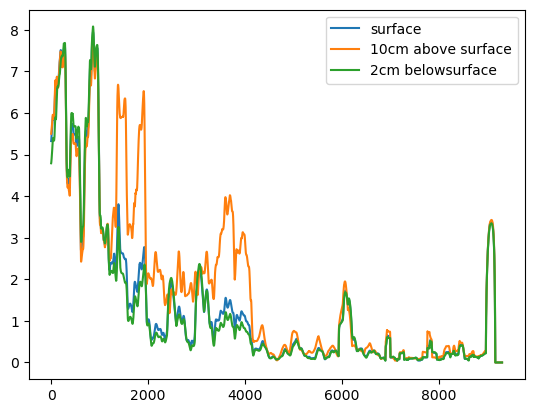

In [15]:
heights = season_data['height']

h=48*4 ## time period that standard deviation is calculated over

known_height = []
above_height = []
below_height = []

std_profiles = []
vert_profiles = []

vertical_subset = np.where((heights<-120)&(heights>-400))[0] ## since we're only looking for the surface cut off lower depths

plt_dates = []

for idx, t in np.ndenumerate(season_data['dates'][:]):
    if t<datetime.datetime(2024,5,15):
        continue
    
    # probably a good idea to base off of datetimes and time deltas to deal with missing data
    t_temp = season_data['temperature'][idx[0]:int(idx[0]+h),:].std(axis=0)
    std_profiles.append(t_temp)

    t_temp_vert = np.gradient(season_data['temperature'][idx[0],vertical_subset])

    vert_profiles.append(t_temp_vert)
    
    plt_dates.append(t)
    known_height.append(t_temp[np.where(heights==-175*2)[0]])
    above_height.append(t_temp[np.where(heights==-175*2+10)[0]])
    below_height.append(t_temp[np.where(heights==-175*2-2)[0]])




plt.plot(known_height, label='surface')
plt.plot(above_height, label='10cm above surface')
plt.plot(below_height, label='2cm belowsurface')
plt.legend(loc='best')
plt.show()

Plot the data saved above, which was most of what I was using to estimate the surface

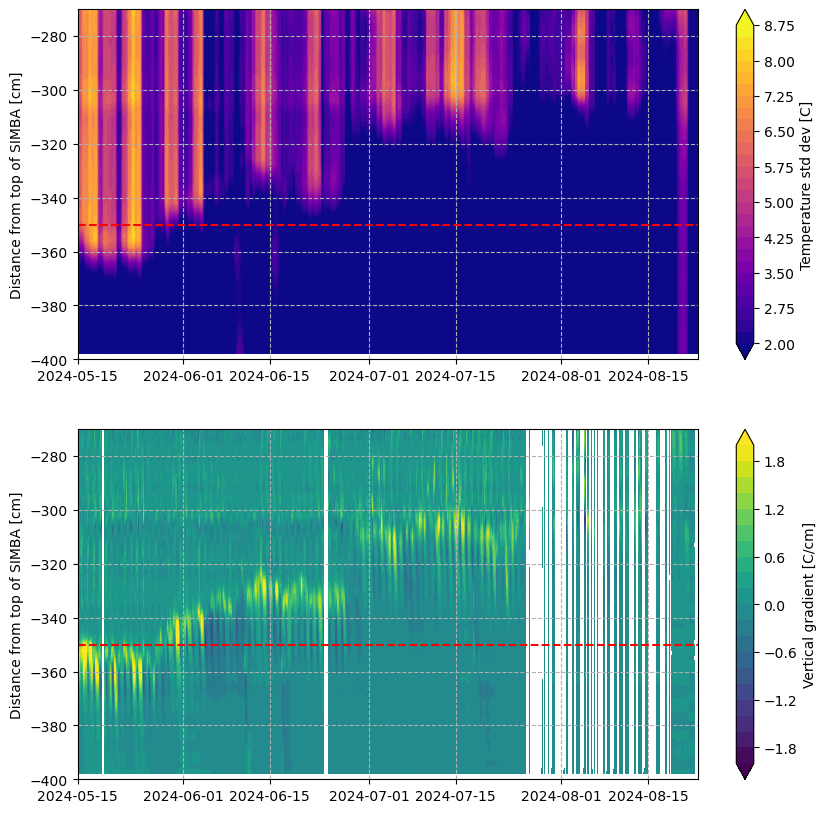

In [14]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)
cb = axs[0].contourf(plt_dates, heights[vertical_subset], np.swapaxes(np.asarray(std_profiles)[:,vertical_subset],0,1),
                cmap=plt.cm.plasma, levels=np.arange(2,9,.25), extend='both')
plt.colorbar(cb, label='Temperature std dev [C]', ax=axs[0])


vert_profiles = np.ma.masked_outside(vert_profiles, -10,10)
cb = axs[1].contourf(plt_dates, heights[vertical_subset], np.swapaxes(vert_profiles,0,1),
                cmap=plt.cm.viridis, levels=np.linspace(-2,2,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[1])

axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')

plt.show()

Here are some additional plots that I commonly use from SIMBAs (vertical temp graident is a repeat)

In [16]:
## temperature dimensions are (time, height)
dTdt = (season_data['temperature'][1:,:] - season_data['temperature'][:-1,:])/(15.*60) # timesteps are 15 minutes
dTdz = (season_data['temperature'][:,1:] - season_data['temperature'][:,:-1])/0.02 # vertical resolution is 2 cm

In [17]:
dTdt_hr = dTdt*60*60 ## convert to per hours so values aren't so small

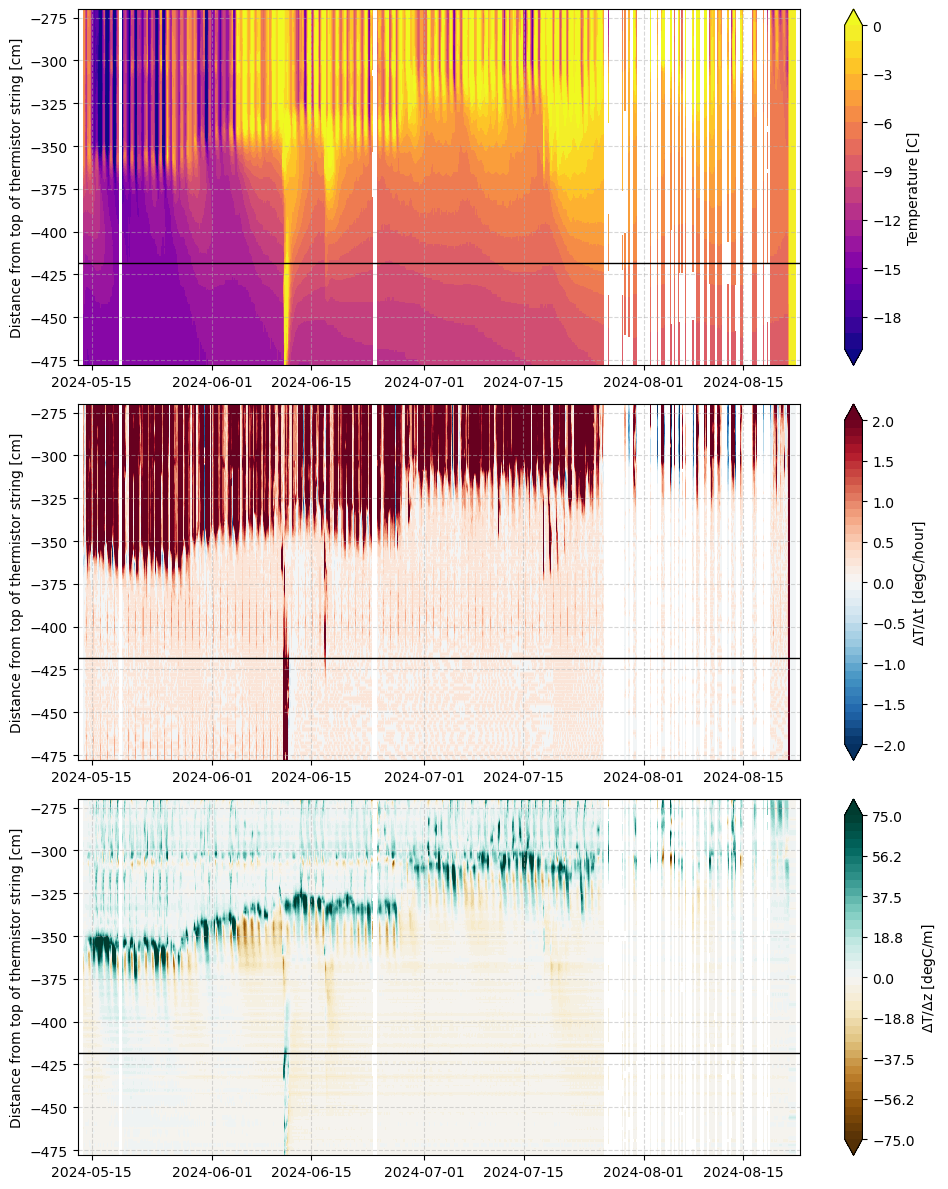

In [21]:
fig, axs = plt.subplots(3, figsize=(10,12))

## figure out pythonic looping later
cb = axs[0].contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=plt.cm.plasma, levels=np.arange(-20,1,1), extend='both')
plt.colorbar(cb, ax=axs[0], label='Temperature [C]')

cb = axs[1].contourf(season_data['dates'][1:], season_data['height'], np.swapaxes(dTdt_hr,0,1), 
                     cmap=plt.cm.RdBu_r, levels=np.linspace(-2,2,41), extend='both')
plt.colorbar(cb, ax=axs[1], label='$\Delta$T/$\Delta$t [degC/hour]')

cb = axs[2].contourf(season_data['dates'], season_data['height'][1:], np.swapaxes(dTdz,0,1), 
                     cmap=plt.cm.BrBG, levels=np.linspace(-75,75,41), extend='both')
plt.colorbar(cb, ax=axs[2], label='$\Delta$T/$\Delta$z [degC/m]')

for ax in axs.ravel():
    ax.set_ylim(-478, -270)
    ax.set_ylabel('Distance from top of thermistor string [cm]')
    ax.grid(alpha=.5, ls='--')
    ax.axhline(y=-209*2, c='k', lw=1) ## top of ice chunk discovered at demob


plt.tight_layout()
plt.show()